In [1]:
import pandas as pd
import json
import re
import spacy
import fitz
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")


In [2]:
with open('data/techmap-jobs_us_2023-05-05.json', 'r') as f:
    data = [json.loads(line) for line in f]

print(f"Loaded {len(data)} job postings.")


Loaded 33064 job postings.


In [3]:
def parse_job_entry(entry):
    try:
        job_title = entry.get('name', '')
        job_text = entry.get('text', '')
        
        # fallback if main text is missing
        if not job_text and 'json' in entry and 'schemaOrg' in entry['json']:
            job_text = entry['json']['schemaOrg'].get('description', '')
        
        return {
            'job_title': job_title.strip(),
            'job_text': job_text.strip()
        }
    except Exception as e:
        print(f"Error parsing entry: {e}")
        return None

parsed_jobs = [parse_job_entry(job) for job in data if parse_job_entry(job) is not None]
jobs_df = pd.DataFrame(parsed_jobs)

print(jobs_df.head())


                                           job_title  \
0                                    Account Manager   
1                       Music Teacher, Band Director   
2                     Floral Clerk FT Chapel Hill NC   
3  Audio and Video Transcription - Flexible Sched...   
4                       Sticker Production Assistant   

                                            job_text  
0  At Legacy Risk, an Alera Group Company, our bu...  
1  DescriptionWe are looking for music educators ...  
2  To provide excellent guest service by performi...  
3  What exactly is a search engine evaluation job...  
4  We are a high-quality printing company operati...  


In [4]:
def clean_and_lemmatize(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()

    # lemmatization
    doc = nlp(text)
    lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return lemmatized

jobs_df['clean_text'] = jobs_df['job_text'].progress_apply(clean_and_lemmatize)


100%|██████████| 33064/33064 [36:12<00:00, 15.22it/s]  


In [6]:
def classify_seniority(title, description):
    title = title.lower()

    if re.search(r'\bintern(ship)?\b', title):
        return "intern"
    if re.search(r'\b(new grad(uate)?|entry[-\s]?level|junior|jr\.)\b', title):
        return "new_grad"
    if re.search(r'\bmid[-\s]?level\b|\bintermediate\b', title):
        return "mid"
    if re.search(r'\bsenior\b|\bsr\.\b|\bprincipal\b', title):
        return "senior"
    if re.search(r'\bchief\b|\bcxo\b|\bexecutive\b|\bdirector\b|\bvp\b|\bvice president\b', title):
        return "executive"

    return "unknown"

jobs_df['seniority'] = jobs_df.apply(
    lambda row: classify_seniority(row['job_title'], row['job_text']), axis=1
)

distribution = jobs_df['seniority'].value_counts()
print("Seniority Class Distribution:")
print(distribution)



Seniority Class Distribution:
seniority
unknown      29831
senior        1284
executive     1143
new_grad       606
intern         160
mid             40
Name: count, dtype: int64


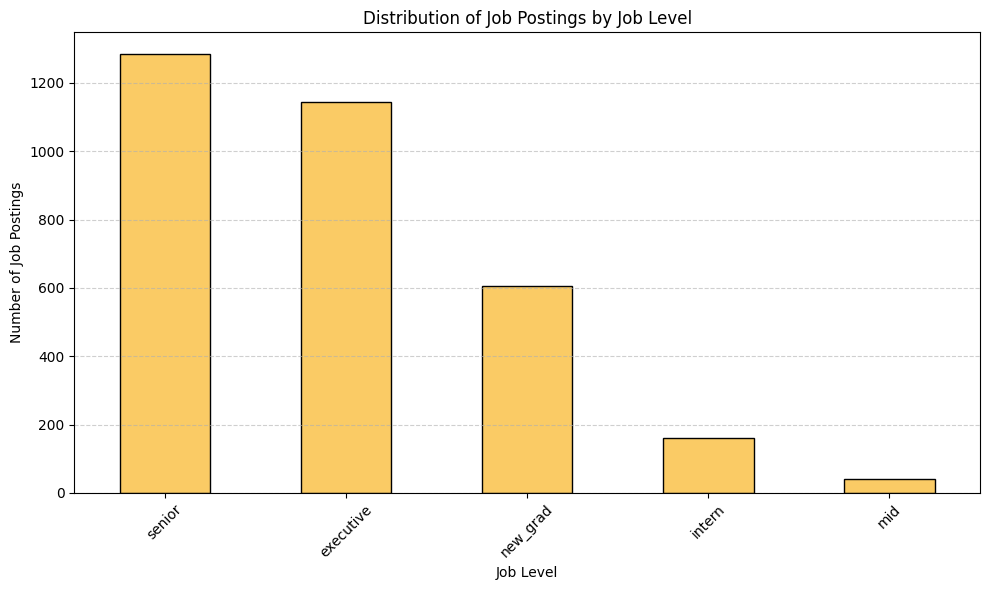

In [7]:
distribution = jobs_df['seniority'].value_counts()

distribution = distribution.drop('unknown', errors='ignore')

plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', color='#FACB65', edgecolor='black')
plt.title('Distribution of Job Postings by Job Level')
plt.xlabel('Job Level')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

pdf_resume_path = "resume/Viswa_Nadimpalli_Resume.pdf"
resume_raw = extract_text_from_pdf(pdf_resume_path)
resume_clean = clean_and_lemmatize(resume_raw)

# print(f"{resume_raw}\n\n\n")
# print(resume_clean)


In [13]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(jobs_df['clean_text'])

def get_tfidf_recommendations(clean_resume_text, tfidf_model, tfidf_matrix, job_df, top_n=10000):
    vec = tfidf_model.transform([clean_resume_text])
    similarities = cosine_similarity(vec, tfidf_matrix)[0]
    return similarities.argsort()[-top_n:][::-1]

tfidf_top = get_tfidf_recommendations(resume_clean, tfidf, tfidf_matrix, jobs_df)


In [14]:
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
job_embeddings = embed_model.encode(jobs_df['clean_text'].tolist(), show_progress_bar=True)

def get_semantic_recommendations(clean_resume_text, embed_model, job_embeddings, job_df, top_n=10000):
    resume_embedding = embed_model.encode([clean_resume_text])[0]
    similarities = cosine_similarity([resume_embedding], job_embeddings)[0]
    return similarities.argsort()[-top_n:][::-1]

semantic_top = get_semantic_recommendations(resume_clean, embed_model, job_embeddings, jobs_df)


Batches:   0%|          | 0/1034 [00:00<?, ?it/s]

In [15]:

sample_indices = [10, 150, 500]  # Change as needed
sample_jobs = jobs_df.iloc[sample_indices]

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# TF-IDF similarity
tfidf_vec = tfidf.transform([resume_clean])
tfidf_scores = cosine_similarity(tfidf_vec, tfidf_matrix[sample_indices])[0]

# MiniLM similarity
resume_embedding = embed_model.encode([resume_clean])[0]
minilm_scores = cosine_similarity([resume_embedding], [job_embeddings[i] for i in sample_indices])[0]

comparison_df = pd.DataFrame({
    'Job Title': sample_jobs['job_title'].values,
    'TF-IDF Score': tfidf_scores,
    'MiniLM Score': minilm_scores,
    'Job Snippet': sample_jobs['clean_text'].str[:100].values  # Shortened for display
})

display(comparison_df)


,Job Title,TF-IDF Score,MiniLM Score,Job Snippet
0,Dance Instructor Litehouse/Sandpoint,0.022670,0.341007,culture y channel passion lifelong career help...
1,Night Auditor - Las Posada De Santa Fe Resort,0.021420,0.428302,job description perform daily audit function o...
2,Research Assistant-Clinical,0.039229,0.374448,arkansas child s tobacco free workplace covid ...


In [16]:
desired_level = "new_grad"  # "intern", "new_grad", "mid", "senior", "executive"

filtered_tfidf_indices = [
    idx for idx in tfidf_top
    if classify_seniority(jobs_df.iloc[idx]['job_title'], jobs_df.iloc[idx]['job_text']) == desired_level
][:5]

print(f"\n🎯 Top TF-IDF Matches (Filtered for: {desired_level}):")
for rank, idx in enumerate(filtered_tfidf_indices, 1):
    print(f"\nRank {rank}:")
    print(f"Job Title: {jobs_df.iloc[idx]['job_title']}")
    print(f"Seniority: {classify_seniority(jobs_df.iloc[idx]['job_title'], jobs_df.iloc[idx]['job_text'])}")
    print(f"Description:\n{jobs_df.iloc[idx]['job_text']}")
    print("-" * 80)

# Filter Semantic recommendations by seniority
filtered_semantic_indices = [
    idx for idx in semantic_top
    if classify_seniority(jobs_df.iloc[idx]['job_title'], jobs_df.iloc[idx]['job_text']) == desired_level
][:5]

print(f"\n🎯 Top Semantic Matches (Filtered for: {desired_level}):")
for rank, idx in enumerate(filtered_semantic_indices, 1):
    print(f"\nRank {rank}:")
    print(f"Job Title: {jobs_df.iloc[idx]['job_title']}")
    print(f"Seniority: {classify_seniority(jobs_df.iloc[idx]['job_title'], jobs_df.iloc[idx]['job_text'])}")
    print(f"Description:\n{jobs_df.iloc[idx]['job_text']}")
    print("-" * 80)



🎯 Top TF-IDF Matches (Filtered for: new_grad):

Rank 1:
Job Title: Junior Level Software Developer
Seniority: new_grad
Description:
Entry-level Software Developer BeaconFire Corporation based in Central NJ, specializing in Software Development, Web Development, and Business Intelligence is looking for candidates with a strong background in Software Engineering, Computer Science, for Java / Software Developer position. Job Responsibilities: · Develop applications using Java 8/JEE (and higher), AngularJS, React.js, SQL, Spring, and HTML5, among other tools. · Write scalable, secure, maintainable code that powers our clients’ platforms. · Create, deploy and maintain automated system tests. · Works with Testers to understand defects opened and resolves them in a timely manner · Support continuous improvement by investigating alternatives and technologies and presenting these for architectural review · Collaborates effectively with other team members to accomplish shared user story and spr